# ECG Beat Annotation UI

Segment-based annotation: scroll through 20s segments, click on any beat to inspect and relabel it.
Annotations are saved to `annotations.csv` for future ML training.

**Workflow:** Scan the top trace visually. Click any beat that looks misclassified. The zoomed view appears below with label buttons. Most beats need no action.

In [1]:
%matplotlib widget

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.insert(0, '.')
from ecg_library.filters import filter_signal
from ecg_library.utils import load_ecg_data, parse_folder
from ecg_library.annotations import load_annotations, save_annotation, get_annotation_status

# Constants
FS = 125
SEGMENT_SEC = 20
SEGMENT_SAMPLES = SEGMENT_SEC * FS
ZOOM_WINDOW = int(0.75 * FS)  # samples each side of R-peak for zoomed view
ANNOTATIONS_PATH = 'annotations.csv'
DATA_DIR = 'Data'

# Color map: algo labels -> marker colors
ALGO_COLORS = {
    'normal': '#2ecc71',
    'PVC': '#e74c3c',
    'VT': '#e67e22',
    'undetected': '#ff00ff',
}
LABEL_COLORS = {
    'Normal': '#2ecc71',
    'PVC': '#e74c3c',
    'VT': '#e67e22',
    'PAC': '#3498db',
    'Artifact': '#95a5a6',
}
VALID_LABELS = list(LABEL_COLORS.keys())

print('Imports OK')

Imports OK


In [2]:
# --- Session loading ---

def find_sessions(data_dir=DATA_DIR):
    """Find all Data/ subfolders that have a rich_processed_beats.csv."""
    sessions = []
    for name in sorted(os.listdir(data_dir)):
        folder = os.path.join(data_dir, name)
        if not os.path.isdir(folder):
            continue
        csvs = glob.glob(os.path.join(folder, '*_rich_processed_beats.csv'))
        if csvs:
            sessions.append(name)
    return sessions


def load_session(session_name, annotations_df):
    """Load a session's signal and beat list, merging existing annotations."""
    folder = os.path.join(DATA_DIR, session_name)
    csv_files = glob.glob(os.path.join(folder, '*_rich_processed_beats.csv'))
    rich_df = pd.read_csv(csv_files[0])

    combined_ecg, combined_time, fs, file_paths = load_ecg_data(folder)
    filtered_ecg = filter_signal(combined_ecg, fs)
    _, start_time = parse_folder(session_name)

    beats = []
    session_annots = annotations_df[annotations_df['session'] == session_name]
    annotated_r_indices = set(session_annots['r_index'].values)

    for _, row in rich_df.iterrows():
        r_idx = int(row['r_index'])
        algo_label = row['beat_type']
        human_label = None
        if r_idx in annotated_r_indices:
            match = session_annots[session_annots['r_index'] == r_idx]
            if len(match) > 0:
                human_label = match.iloc[0]['human_label']

        beats.append({
            'r_index': r_idx,
            'algo_label': algo_label,
            'human_label': human_label,
            'abs_r_time': row.get('abs_r_time', ''),
            'r_amplitude': row.get('r_amplitude', ''),
            'rr_interval': row.get('rr_interval', ''),
            'qrs_duration': row.get('qrs_duration', ''),
            'qt_interval': row.get('qt_interval', ''),
            'p_index': row.get('p_index', None),
            'q_index': row.get('q_index', None),
            's_index': row.get('s_index', None),
            't_index': row.get('t_index', None),
        })

    # Also load any manually-added beats from annotations that aren't in the rich CSV
    rich_r_indices = set(int(row['r_index']) for _, row in rich_df.iterrows())
    for _, arow in session_annots.iterrows():
        r_idx = int(arow['r_index'])
        if r_idx not in rich_r_indices:
            beats.append({
                'r_index': r_idx,
                'algo_label': 'undetected',
                'human_label': arow['human_label'],
                'abs_r_time': arow.get('abs_r_time', ''),
                'r_amplitude': arow.get('r_amplitude', ''),
                'rr_interval': arow.get('rr_interval', ''),
                'qrs_duration': arow.get('qrs_duration', ''),
                'qt_interval': '',
                'p_index': None, 'q_index': None, 's_index': None, 't_index': None,
            })

    # Keep beats sorted by r_index (time order) for segment view
    beats.sort(key=lambda b: b['r_index'])
    return filtered_ecg, combined_time, beats, start_time


sessions = find_sessions()
print(f'Found {len(sessions)} sessions with processed beats')

Found 235 sessions with processed beats


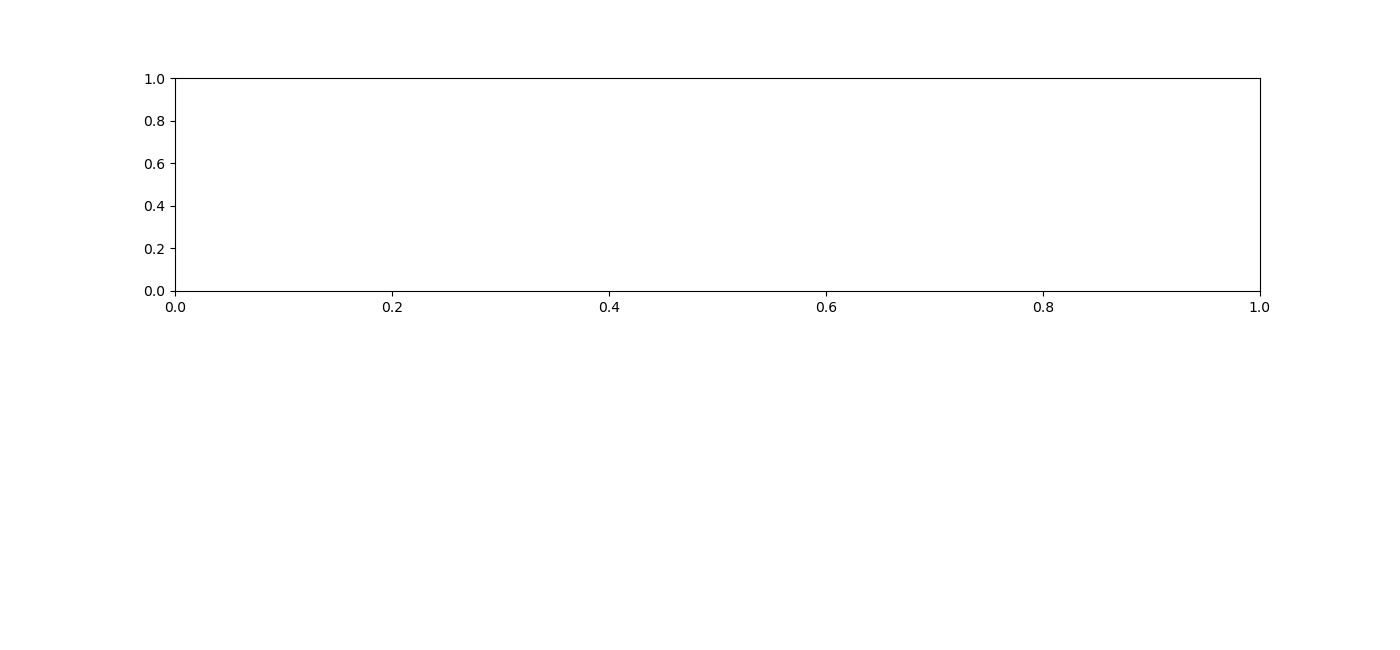

In [3]:
# --- Segment-based Annotation UI ---

from datetime import timedelta
from scipy.signal import find_peaks

state = {
    'session': None,
    'filtered_ecg': None,
    'combined_time': None,
    'start_time': None,
    'beats': [],
    'seg_idx': 0,          # current segment index
    'n_segments': 0,
    'selected_beat': None,  # index into beats list
}

# --- Widgets ---
session_dropdown = widgets.Dropdown(
    options=['-- Select --'] + sessions,
    value='-- Select --',
    description='Session:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': '65px'},
)
progress_label = widgets.HTML(value='<i>Select a session to begin.</i>')
info_label = widgets.HTML(value='')

btn_prev_seg = widgets.Button(description='\u2190 Prev 20s', layout=widgets.Layout(width='120px'))
btn_next_seg = widgets.Button(description='Next 20s \u2192', layout=widgets.Layout(width='120px'))
btn_deselect = widgets.Button(description='Deselect', layout=widgets.Layout(width='100px'),
                              style={'button_color': '#ecf0f1'})

label_buttons = {}
for lbl in VALID_LABELS:
    label_buttons[lbl] = widgets.Button(
        description=lbl,
        layout=widgets.Layout(width='100px', height='36px'),
        style={'button_color': LABEL_COLORS[lbl]},
    )
label_row = widgets.HBox(list(label_buttons.values()),
                         layout=widgets.Layout(visibility='hidden'))

# Create persistent figure with two subplots
fig, (ax_seg, ax_zoom) = plt.subplots(
    2, 1, figsize=(14, 6.5),
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.35},
)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
ax_zoom.set_visible(False)


# --- Drawing functions ---

def get_segment_range():
    """Return (start_sample, end_sample) for current segment."""
    start = state['seg_idx'] * SEGMENT_SAMPLES
    end = min(start + SEGMENT_SAMPLES, len(state['filtered_ecg']))
    return start, end


def beats_in_segment():
    """Return list of (index_into_beats, beat_dict) for beats in current segment."""
    start, end = get_segment_range()
    result = []
    for i, b in enumerate(state['beats']):
        if start <= b['r_index'] < end:
            result.append((i, b))
    return result


def effective_label(beat):
    """Return the label to display: human_label if set, otherwise algo_label."""
    return beat['human_label'] if beat['human_label'] else beat['algo_label']


def label_color(beat):
    """Return marker color for a beat based on its effective label."""
    lbl = effective_label(beat)
    if lbl in LABEL_COLORS:
        return LABEL_COLORS[lbl]
    if lbl == 'undetected':
        return '#ff00ff'  # magenta for undetected beats awaiting label
    return ALGO_COLORS.get(lbl, '#888888')


def draw_segment():
    """Draw the 20s segment view with all beat markers."""
    sig = state['filtered_ecg']
    t = state['combined_time']
    start, end = get_segment_range()

    ax_seg.cla()
    ax_seg.plot(t[start:end], sig[start:end], color='#2c3e50', linewidth=0.6)

    seg_beats = beats_in_segment()
    for i, beat in seg_beats:
        r = beat['r_index']
        color = label_color(beat)
        is_selected = (state['selected_beat'] == i)

        # Marker at R-peak
        marker_size = 10 if is_selected else 6
        edge = 'black' if is_selected else 'none'
        marker = 'D' if beat['algo_label'] == 'undetected' else 'o'
        ax_seg.plot(t[r], sig[r], marker, color=color, markersize=marker_size,
                    markeredgecolor=edge, markeredgewidth=1.5, zorder=5)

        # Label text above
        lbl_text = effective_label(beat)
        if lbl_text == 'normal':
            lbl_text = 'N'
        elif lbl_text == 'undetected':
            lbl_text = '?'
        elif beat['human_label']:
            lbl_text = f'[{lbl_text}]'  # brackets = human-reviewed
        fontsize = 9 if beat['algo_label'] in ('PVC', 'VT', 'undetected') or beat['human_label'] else 7
        ax_seg.annotate(lbl_text, (t[r], sig[r]), textcoords='offset points',
                        xytext=(0, 12), ha='center', fontsize=fontsize,
                        fontweight='bold', color=color)

        # Highlight selected beat
        if is_selected:
            hw = int(0.3 * FS)  # highlight half-width
            hl = max(start, r - hw)
            hr = min(end - 1, r + hw)
            ax_seg.axvspan(t[hl], t[hr], alpha=0.12, color='#3498db')

    ax_seg.set_title(
        f'Segment {state["seg_idx"]+1}/{state["n_segments"]}  '
        f'({t[start]:.1f}s \u2013 {t[min(end-1, len(t)-1)]:.1f}s)  '
        f'\u2014 Click a beat to relabel, or click empty space to add a missed beat',
        fontsize=10, loc='left'
    )
    ax_seg.set_ylabel('Amplitude')
    ax_seg.tick_params(labelsize=8)


def draw_zoomed():
    """Draw zoomed view of selected beat, or hide if none selected."""
    ax_zoom.cla()
    if state['selected_beat'] is None:
        ax_zoom.set_visible(False)
        info_label.value = ''
        label_row.layout.visibility = 'hidden'
        fig.canvas.draw_idle()
        return

    ax_zoom.set_visible(True)
    label_row.layout.visibility = 'visible'
    beat = state['beats'][state['selected_beat']]
    sig = state['filtered_ecg']
    t = state['combined_time']
    r = beat['r_index']
    sig_len = len(sig)

    # Zoomed window
    z_start = max(0, r - ZOOM_WINDOW)
    z_end = min(sig_len, r + ZOOM_WINDOW)
    ax_zoom.plot(t[z_start:z_end], sig[z_start:z_end], color='#2c3e50', linewidth=1.0)
    ax_zoom.axvline(t[r], color='#e74c3c', linewidth=0.8, alpha=0.3, linestyle='--')

    # PQRST markers
    pqrst = [
        ('P', beat.get('p_index'), '#9b59b6'),
        ('Q', beat.get('q_index'), '#2980b9'),
        ('R', r, '#e74c3c'),
        ('S', beat.get('s_index'), '#16a085'),
        ('T', beat.get('t_index'), '#f39c12'),
    ]
    for name, idx, color in pqrst:
        if idx is not None and not (isinstance(idx, float) and np.isnan(idx)):
            idx = int(idx)
            if 0 <= idx < sig_len:
                ax_zoom.plot(t[idx], sig[idx], 'o', color=color, markersize=8, zorder=5)
                ax_zoom.annotate(name, (t[idx], sig[idx]), textcoords='offset points',
                                 xytext=(0, 12), ha='center', fontsize=10,
                                 fontweight='bold', color=color)

    algo_str = beat["algo_label"]
    if algo_str == 'undetected':
        algo_str = 'MISSED (manually added)'
    human_str = f' \u2192 Human: {beat["human_label"]}' if beat['human_label'] else ''
    ax_zoom.set_title(f'Selected Beat  |  Algo: {algo_str}{human_str}',
                      fontsize=10, loc='left')
    ax_zoom.set_xlabel('Time (s)')
    ax_zoom.set_ylabel('Amplitude')
    ax_zoom.tick_params(labelsize=8)

    # Info label
    def fmt(val, suffix=''):
        if val is None or val == '' or (isinstance(val, float) and np.isnan(val)):
            return 'N/A'
        return f'{val:.3f}{suffix}' if isinstance(val, float) else f'{val}{suffix}'

    info_label.value = (
        f'RR={fmt(beat["rr_interval"], "s")} &nbsp;| '
        f'QRS={fmt(beat["qrs_duration"], "s")} &nbsp;| '
        f'QT={fmt(beat["qt_interval"], "s")} &nbsp;| '
        f'R-amp={fmt(beat["r_amplitude"])} &nbsp;| '
        f'Algo: <b>{algo_str}</b>'
        + (f' &nbsp;| Human: <b>{beat["human_label"]}</b>' if beat['human_label'] else '')
    )


def render():
    """Redraw both axes and update status."""
    draw_segment()
    draw_zoomed()
    update_progress()
    fig.canvas.draw_idle()


def update_progress():
    beats = state['beats']
    total = len(beats)
    annotated = sum(1 for b in beats if b['human_label'] is not None)
    seg_beats = beats_in_segment()
    seg_annotated = sum(1 for _, b in seg_beats if b['human_label'] is not None)
    progress_label.value = (
        f'Segment <b>{state["seg_idx"]+1}/{state["n_segments"]}</b> '
        f'({len(seg_beats)} beats, {seg_annotated} reviewed) &nbsp;| '
        f'Session total: <b>{annotated}</b>/{total} annotated'
    )


# --- Manual beat addition ---

def find_local_peak(click_sample):
    """Find the highest local peak near click_sample (within +/- 0.3s)."""
    sig = state['filtered_ecg']
    search_half = int(0.3 * FS)  # 0.3s each side
    lo = max(0, click_sample - search_half)
    hi = min(len(sig), click_sample + search_half)
    chunk = sig[lo:hi]

    # Use find_peaks on absolute value to catch both positive and inverted R-peaks
    peaks, props = find_peaks(chunk, distance=5)
    if len(peaks) == 0:
        # Fallback: just use the maximum
        return lo + int(np.argmax(np.abs(chunk)))

    # Pick the peak with the largest absolute amplitude
    peak_amps = np.abs(chunk[peaks])
    best = peaks[np.argmax(peak_amps)]
    return lo + best


def add_manual_beat(peak_sample):
    """Create a new beat entry for a missed R-peak and insert it into the sorted list."""
    sig = state['filtered_ecg']
    t = state['combined_time']
    r_amp = int(sig[peak_sample])

    # Compute abs_r_time from session start_time
    abs_r_time = ''
    if state['start_time'] is not None:
        abs_r_time = str(state['start_time'] + timedelta(seconds=t[peak_sample]))

    # Compute RR interval from nearest neighbors
    r_indices = [b['r_index'] for b in state['beats']]
    rr_interval = ''
    if r_indices:
        # Find the beat just before this one
        prev_beats = [ri for ri in r_indices if ri < peak_sample]
        if prev_beats:
            rr_interval = (peak_sample - max(prev_beats)) / FS

    new_beat = {
        'r_index': peak_sample,
        'algo_label': 'undetected',
        'human_label': None,
        'abs_r_time': abs_r_time,
        'r_amplitude': r_amp,
        'rr_interval': rr_interval,
        'qrs_duration': '',
        'qt_interval': '',
        'p_index': None, 'q_index': None, 's_index': None, 't_index': None,
    }

    # Insert into sorted position
    insert_pos = 0
    for i, b in enumerate(state['beats']):
        if b['r_index'] > peak_sample:
            break
        insert_pos = i + 1
    state['beats'].insert(insert_pos, new_beat)
    return insert_pos


# --- Click handler ---

def on_click(event):
    """Click on segment plot: select existing beat, or add missed beat in empty space."""
    if event.inaxes != ax_seg or event.xdata is None:
        return

    click_time = event.xdata
    t = state['combined_time']
    seg_beats = beats_in_segment()

    # Find nearest existing R-peak
    best_i = None
    best_dist = float('inf')
    for i, beat in seg_beats:
        dist = abs(t[beat['r_index']] - click_time)
        if dist < best_dist:
            best_dist = dist
            best_i = i

    if best_dist <= 0.3:
        # Close to an existing beat — select it
        state['selected_beat'] = best_i
        render()
        return

    # Clicked in empty space — find local peak and add a manual beat
    click_sample = int(np.argmin(np.abs(t - click_time)))
    peak_sample = find_local_peak(click_sample)

    # Make sure we're not duplicating an existing beat (within 10 samples)
    for b in state['beats']:
        if abs(b['r_index'] - peak_sample) < 10:
            # Already exists, just select it
            state['selected_beat'] = state['beats'].index(b)
            render()
            return

    insert_pos = add_manual_beat(peak_sample)
    state['selected_beat'] = insert_pos
    render()


fig.canvas.mpl_connect('button_press_event', on_click)


# --- Button callbacks ---

def on_session_change(change):
    if change['new'] == '-- Select --':
        return
    session_name = change['new']
    state['session'] = session_name
    annotations_df = load_annotations(ANNOTATIONS_PATH)
    filtered_ecg, combined_time, beats, start_time = load_session(session_name, annotations_df)
    state['filtered_ecg'] = filtered_ecg
    state['combined_time'] = combined_time
    state['beats'] = beats
    state['start_time'] = start_time
    state['n_segments'] = max(1, int(np.ceil(len(filtered_ecg) / SEGMENT_SAMPLES)))
    state['seg_idx'] = 0
    state['selected_beat'] = None
    render()


def on_prev_seg(btn):
    if state['seg_idx'] > 0:
        state['seg_idx'] -= 1
        state['selected_beat'] = None
        render()


def on_next_seg(btn):
    if state['seg_idx'] < state['n_segments'] - 1:
        state['seg_idx'] += 1
        state['selected_beat'] = None
        render()


def on_deselect(btn):
    state['selected_beat'] = None
    render()


def make_label_callback(label):
    def on_label(btn):
        if state['selected_beat'] is None:
            return
        beat = state['beats'][state['selected_beat']]
        metadata = {
            'abs_r_time': beat['abs_r_time'],
            'r_amplitude': beat['r_amplitude'],
            'rr_interval': beat['rr_interval'],
            'qrs_duration': beat['qrs_duration'],
        }
        save_annotation(
            session=state['session'],
            r_index=beat['r_index'],
            algo_label=beat['algo_label'],
            human_label=label,
            metadata=metadata,
            path=ANNOTATIONS_PATH,
        )
        beat['human_label'] = label
        render()
    return on_label


# Wire callbacks
session_dropdown.observe(on_session_change, names='value')
btn_prev_seg.on_click(on_prev_seg)
btn_next_seg.on_click(on_next_seg)
btn_deselect.on_click(on_deselect)
for lbl in VALID_LABELS:
    label_buttons[lbl].on_click(make_label_callback(lbl))

# Layout
nav_row = widgets.HBox([btn_prev_seg, btn_next_seg, btn_deselect])
ui = widgets.VBox([
    session_dropdown,
    progress_label,
    nav_row,
    fig.canvas,
    info_label,
    label_row,
])

display(ui)